In [ ]:
#import sys
#!{sys.executable} -m pip install xgboost

In [15]:
import xgboost as xgb

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [8]:
from preprocessing_wrapper import load_preprocessed_data

pd.options.mode.chained_assignment = None  # default='warn'

data = load_preprocessed_data(cleaning=False, missing_value=False, cat_encoding=False,
                           scaling=False, pca=False, OneHotEncoding = False, LabelEncoding = False)
data = data.drop(columns = ["Listing_ID", "Host_ID", "Postal_Code", "Host_Response_Rate", "Host_Response_Time"])

features = data.columns.drop("Price")
target = 'Price'

#data = airbnb_PCA_n(data, features, target, 80)

# Create X and Y, the target value from data
X = data.drop(columns=['Price'])
Y = data[['Price']]

In [85]:
from Reg import stratify

stratified_price = pd.qcut(Y['Price'], 10)
X['strat_price'] = stratified_price

# x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=X['strat_price'], test_size=0.2)
x_train = x_train.drop(columns=["strat_price"])
x_test = x_test.drop(columns=["strat_price"])

print('strat_price' in x_train.columns)


False


In [24]:
import time as t

In [30]:
error = []
nb_iter = 50
max_exec_time = 0
worst_rmse = 0
best_sets = {}


for iter in range(nb_iter):
    
    chrono = 0
    begin = t.time()
    
    #stratified_price = pd.qcut(Y['Price'], 20)
    #X['strat_price'] = stratified_price

    # x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    #x_train = x_train.drop(columns=["strat_price"])
    #x_test = x_test.drop(columns=["strat_price"])
    
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                                 random_state=42,
                                 max_depth=5,
                                 subsample=1,
                                 colsample_bytree=0.4,
                                 learning_rate=0.05,
                                 gamma=0,
                                 eta=0.1,
                                 n_estimators=100
    ).fit(x_train, y_train)
    predictions = xgb_model.predict(x_test)
    rmse = mean_squared_error(y_test, predictions, squared = False)
    if rmse > worst_rmse:
        worst_rmse = rmse
        worst_sets = {'x_train':x_train, 'x_test':x_test, 'y_train':y_train, 'y_test':y_test}
    error.append(rmse)
    end = t.time()
    chrono = end - begin
    if chrono > max_exec_time:
        max_exec_time = chrono

print("Total tries: ", error)
print("Average RMSE: ", sum(error)/len(error))
print("Worst RMSE: ", max(error))
print("Best RMSE: ", min(error))
print("Worst execution time : ", max_exec_time)


Total tries:  [38.34624757622696, 38.59387800385164, 34.565726689300334, 30.78616936223947, 38.22105646494104, 35.97247255300063, 32.78515875940403, 42.351939050562606, 33.49926162560499, 35.58181228372634, 37.48042761589403, 45.40599539728817, 36.15654202330394, 38.69619036224452, 35.42129508152536, 34.466377857810215, 41.62168645650122, 38.186515915738354, 43.49646612589918, 39.13312544803859, 35.35123974851438, 43.41785074119848, 35.51904771040208, 33.242291406177095, 35.98243734485244, 39.65702033646423, 35.09154525639012, 39.39098561846198, 39.44755409253715, 34.44973319311072, 35.60037700479704, 33.83986869491179, 40.12981885603801, 42.958703338323964, 34.73697211701798, 39.96751584536113, 39.328251360636706, 35.42305515438675, 34.489155606889874, 34.64187285552378, 39.85073067617221, 37.72457782545848, 33.87160406812165, 41.86079296420102, 38.51969485984077, 42.250798182326044, 41.1464456993177, 33.61066016201983, 40.442301661278165, 44.90757170335891]
Average RMSE:  37.75237637

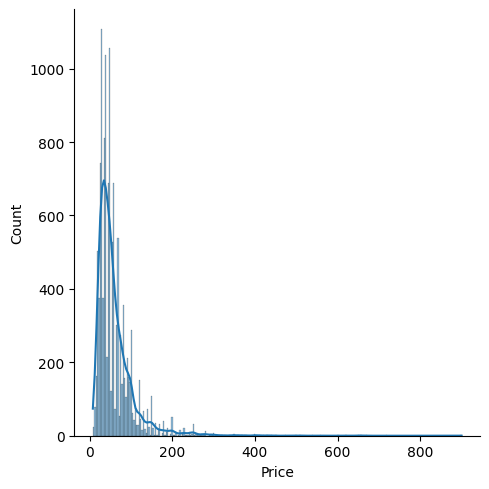

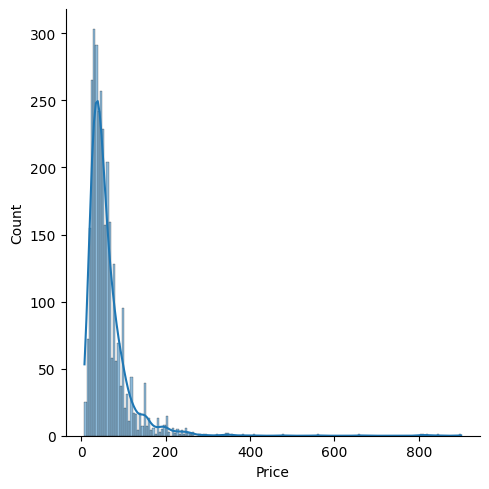

In [32]:
import seaborn as sns

sns.displot(worst_sets['y_train']['Price'], kde=True)
plt.savefig(f'Figures/Price_worst_train.png')

sns.displot(worst_sets['y_test']['Price'], kde=True)
plt.savefig(f'Figures/Price_worst_test.png')

C:\Users\robin\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


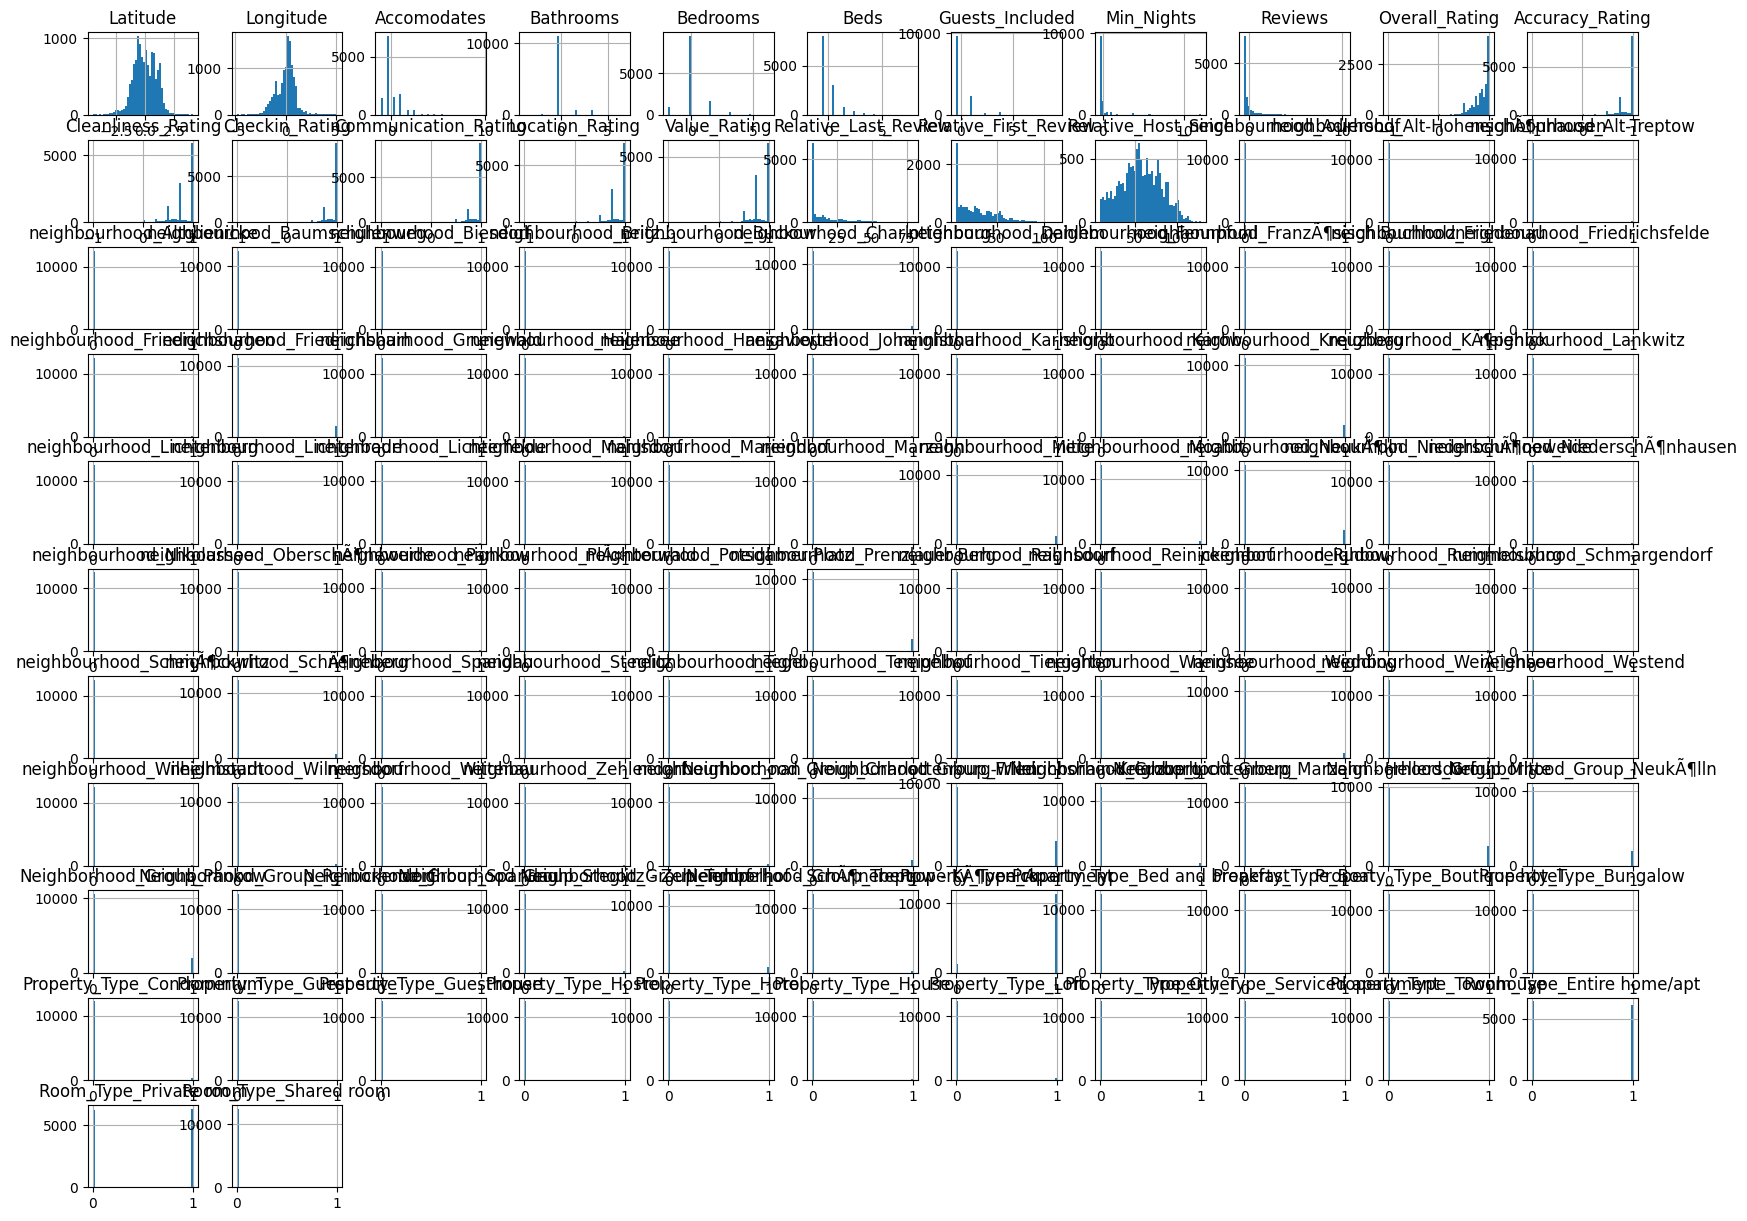

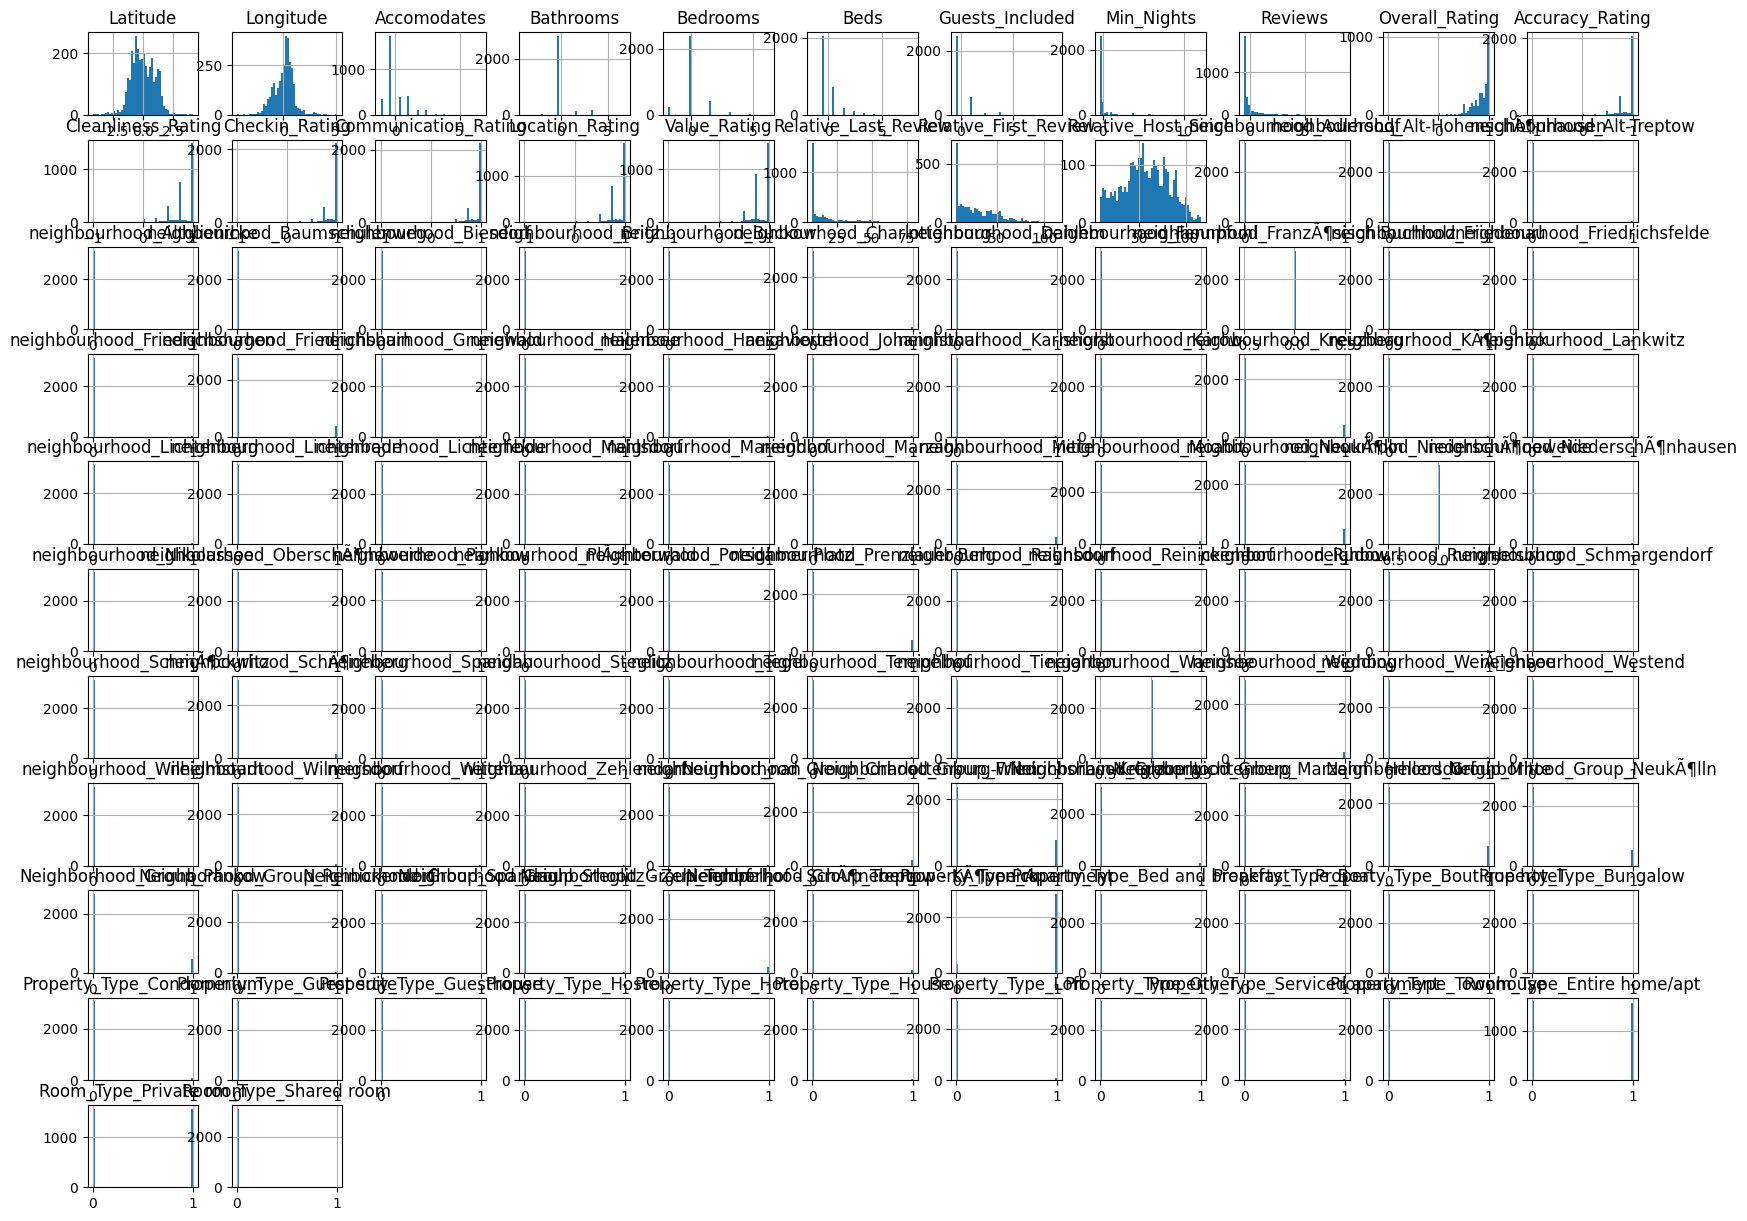

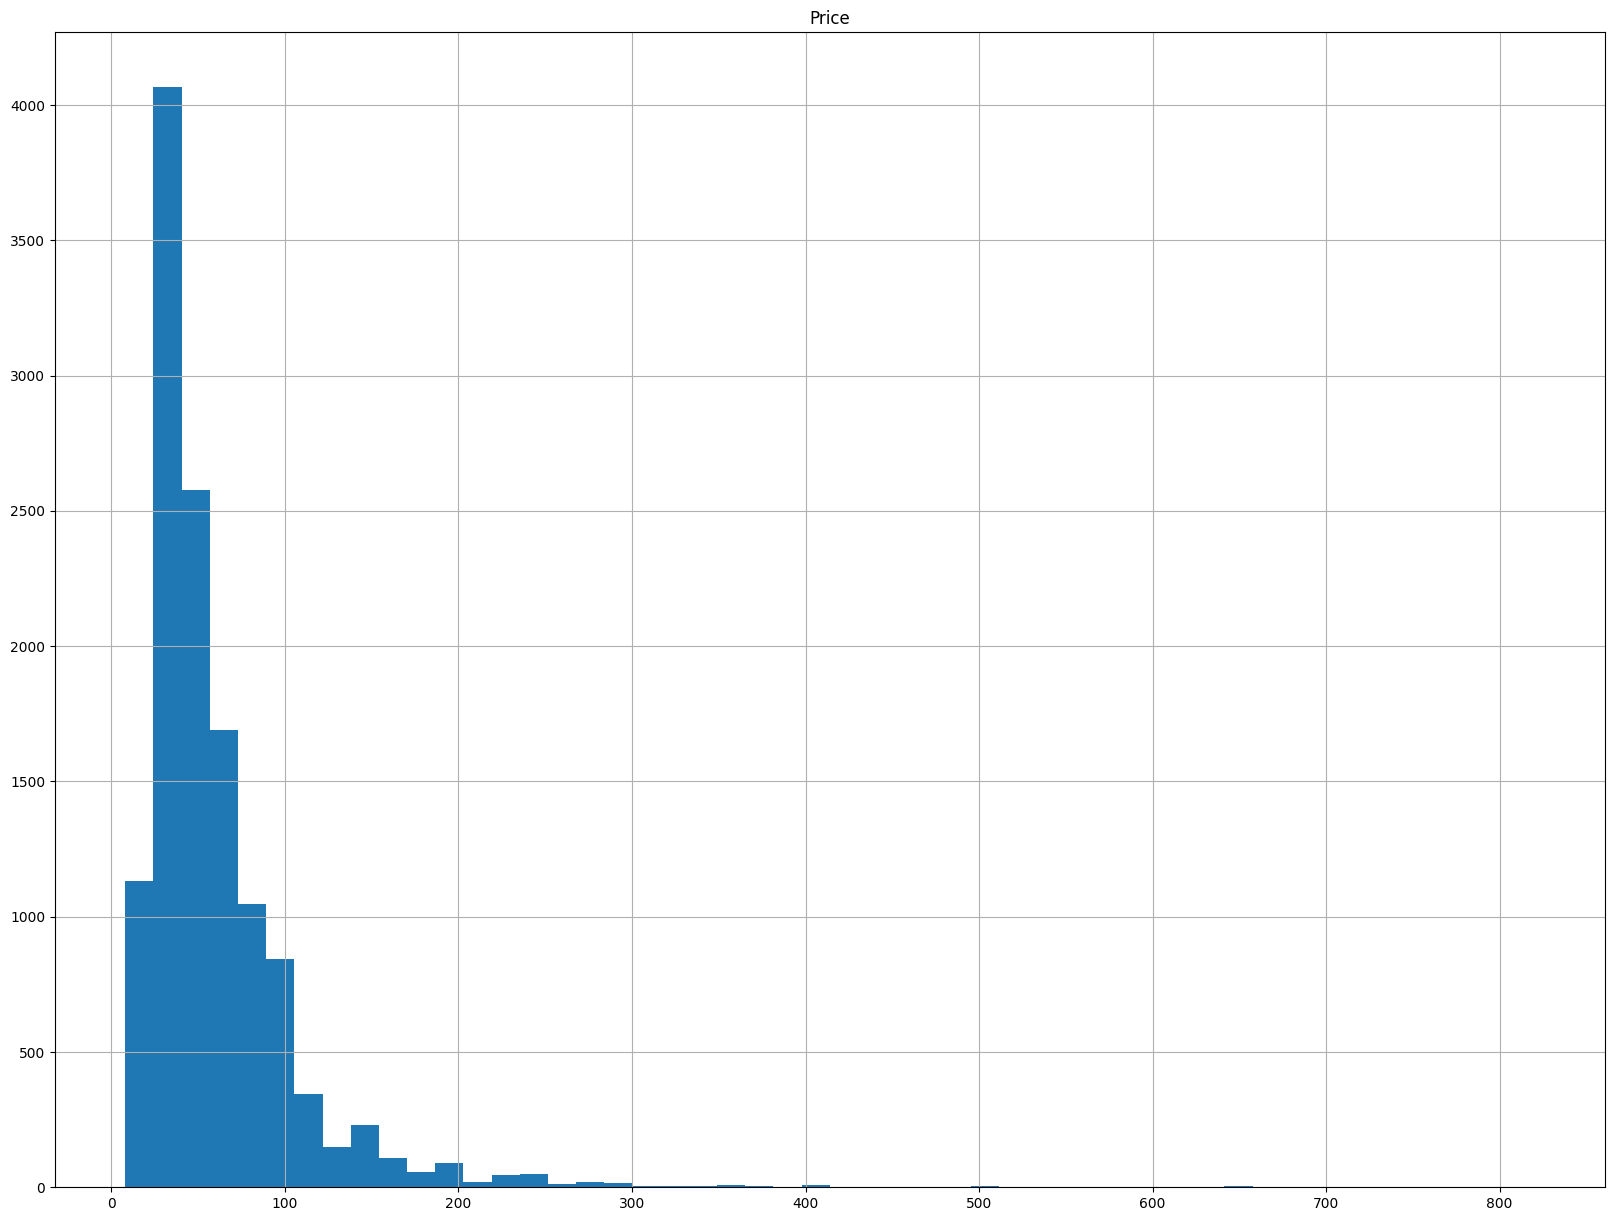

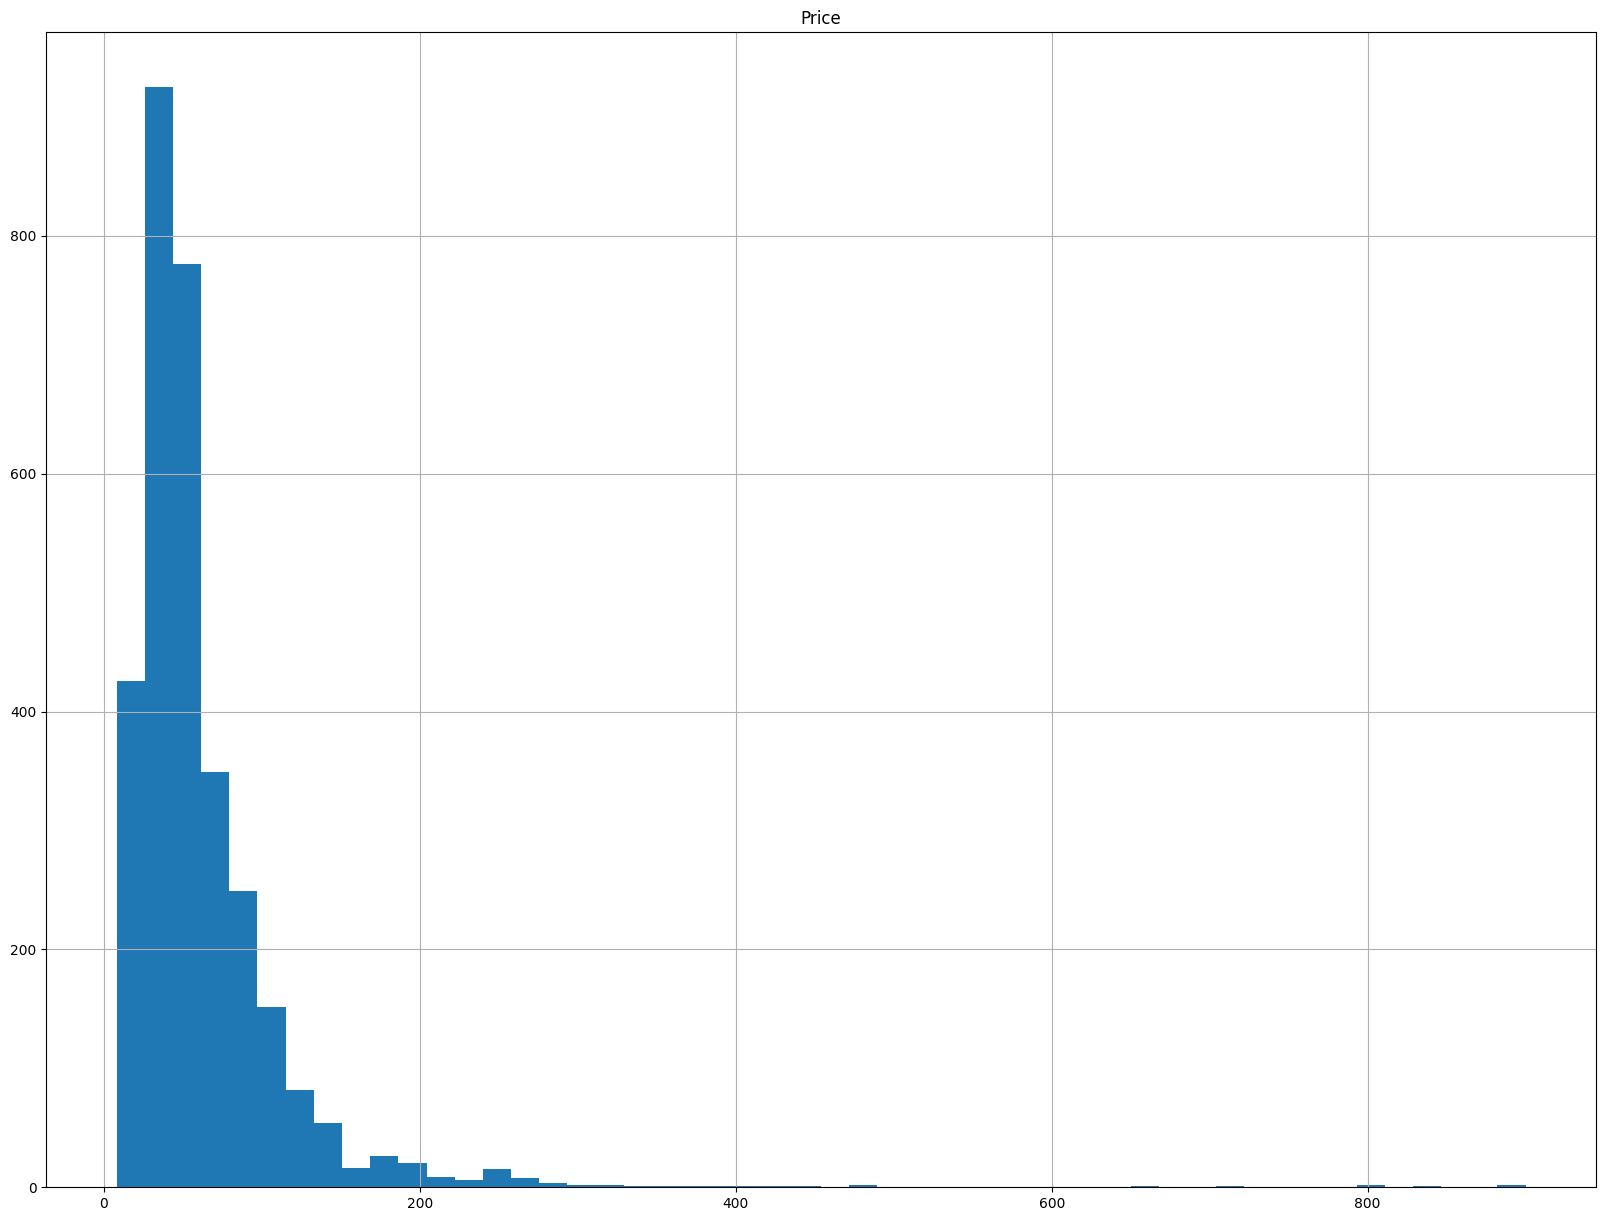

In [27]:
for set_name, set in worst_sets.items():
    set.hist(bins=50, figsize=(20, 15))
    plt.show()

In [97]:
for set_name, set in best_sets.items():
    set.to_csv(f"Data/best_dataset_{set_name}.csv")

In [74]:
print("Parameter optimization")
xgb_model = xgb.XGBRegressor(n_jobs=1)

# On fixe eta = 0.1 pour le moment
params = {
        #'eta': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        'n_estimators': [50, 100, 200, 500],
        'gamma': [0.1, 1, 5],
        'max_depth': [3, 4, 5, 6, 7],
        'eta': [0.01, 0.1, 0.3, 0.7]
}

clf = GridSearchCV(xgb_model,
                   params,
                   verbose=1, n_jobs=1,)
clf.fit(X, Y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [21]:
print("Parameter optimization")
xgb_model = xgb.XGBRegressor(n_jobs=1)

# On fixe eta = 0.1 pour le moment
params = {
        #'eta': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        'n_estimators': [50, 100, 200, 500],
        'gamma': [0.00001, 0.001, 0.1],
        'max_depth': [3],
        'eta': [0.1]
}

clf = GridSearchCV(xgb_model,
                   params,
                   verbose=1, n_jobs=1,)
clf.fit(X, Y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.37640462366046945
{'eta': 0.1, 'gamma': 1e-05, 'max_depth': 3, 'n_estimators': 100}


In [34]:
from Cross_validation import cross_validation

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             random_state=42,
                             max_depth=5,
                             subsample=1,
                             colsample_bytree=0.4,
                             learning_rate=0.05,
                             gamma=0,
                             eta=0.1,
)

cross_validation(xgb_model, 5, X, Y, pca=False)

Accuracy for each fold :
[0.38775644911620155, 0.4443578344602449, 0.3651032971349858, 0.4335819502885888, 0.4512463861657491]
Mean of accuracy : 0.41640918343315403
 
Mse for each fold :
[38.54099976829729, 37.600194997388215, 39.03862897308688, 37.030615821415715, 34.16554749497381]
Mean of mse : 37.27519741103238


(0.41640918343315403, 37.27519741103238)

In [11]:
from Cross_validation import cross_validation

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             random_state=42,
                             max_depth=5,
                             subsample=1,
                             colsample_bytree=0.4,
                             learning_rate=0.05,
                             gamma=0,
                             eta=0.1,
)

cross_validation(xgb_model, 5, X, Y, pca=False)

Accuracy for each fold :
[0.4083268997623761, 0.37910785053981255, 0.4523665294734722, 0.3867981448391299, 0.37085811754894593]
Mean of accuracy : 0.39949150843274733
 
Mse for each fold :
[35.13355211844425, 43.70450040549473, 33.85278714769345, 38.69661888378434, 38.9560697979765]
Mean of mse : 38.06870567067865


(0.39949150843274733, 38.06870567067865)

In [21]:
from sklearn.model_selection import StratifiedKFold
import os
import pandas as pd
import statistics as st
from sklearn import metrics
from PCA import airbnb_PCA_n

def stratified_cross_validation(clf,K,X,Y,pca:bool=False):
    cv=StratifiedKFold(K)
    accu=[]
    mse=[]
    r2=[]
    for train_index, test_index in cv.split(X, Y):
        x_train, y_train = X.iloc[train_index], Y.iloc[train_index]
        x_test, y_test = X.iloc[test_index], Y.iloc[test_index]
        if pca:
            x_train, x_test = airbnb_PCA_n(x_train, x_test, 80)
        clf.fit(x_train, y_train)
        pred=clf.predict(x_test)
        accu.append(clf.score(x_test,y_test))
        mse.append(metrics.mean_squared_error(y_test, pred, squared = False))
        r2.append(metrics.r2_score(y_test, pred))
    print("Accuracy for each fold :")
    print(accu)
    print("Mean of accuracy :",st.mean(accu))
    print(" ")
    print("Mse for each fold :")
    print(mse)
    print("Mean of mse :",st.mean(mse))
    print(" ")
    print("R2 for each fold :")
    print(r2)
    print("Mean of r2 :",st.mean(r2))
    return (st.mean(accu),st.mean(mse), st.mean(r2))

In [36]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             random_state=42,
                             max_depth=5,
                             subsample=1,
                             colsample_bytree=0.4,
                             learning_rate=0.05,
                             gamma=0,
                             eta=0.1,
)

stratified_cross_validation(xgb_model, 5, X, Y, pca=False)

C:\Users\robin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for each fold :
[0.3948407148641454, 0.4707352024473922, 0.43367778077467245, 0.39682059397556435, 0.4125158483591884]
Mean of accuracy : 0.42171802808419256
 
Mse for each fold :
[38.267669237102034, 33.76856787930377, 35.579256575410874, 40.444220398141496, 37.54430477149255]
Mean of mse : 37.120803772290145
 
R2 for each fold :
[0.3948407148641454, 0.4707352024473922, 0.43367778077467245, 0.39682059397556435, 0.4125158483591884]
Mean of r2 : 0.42171802808419256


(0.42171802808419256, 37.120803772290145, 0.42171802808419256)

In [17]:
import os

input_dir = os.path.join(os.getcwd(), "Data")
data_path = os.path.join(input_dir, 'Stratified_test_set.csv')
test_data = pd.read_csv(data_path)

test_data = test_data.drop(columns = ["Listing_ID", "Host_ID", "Postal_Code", "Host_Response_Rate", "Host_Response_Time"])

x_test = test_data.drop(columns=['Price'])
y_test = test_data['Price']


xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             random_state=42,
                             max_depth=5,
                             subsample=1,
                             colsample_bytree=0.4,
                             learning_rate=0.05,
                             gamma=0,
                             eta=0.1,
)

xgb_model.fit(X,Y)

predictions = xgb_model.predict(x_test)
rmse = mean_squared_error(y_test, predictions, squared = False)
r2 = r2_score(y_test, predictions)
print(rmse)
print(r2)




34.73659567695426
0.4594323240198376
